In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from glob import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle
import torch

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from ensemble_boxes import weighted_boxes_fusion

from IPython.display import Image
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [3]:
CONF = 0
IOU = 0.4
AUGMENT = True # True
SIZE = int(1280 * 1.3)  # 1280 * 1.3 
#USE_CLACHE = True
USE_SAHI = False

# Load Data

In [4]:
INPUT_DIR = Path("../../data/tensorflow-great-barrier-reef/")
df = pd.read_csv(INPUT_DIR / "train.csv")
#folds = pd.read_csv("../input/train_folds_balanced.csv") #_CPF
#df = pd.merge(df, folds[["video_id","video_frame","fold"]], on=["video_id",'video_frame'])
df["fold"] = df["video_id"]
df.shape

(23501, 7)

In [5]:
data_param = {'root_dir':INPUT_DIR,'label_dir':INPUT_DIR / "labels"}
df = df.progress_apply(lambda x: util.get_path(x, data_param, infer=True), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [6]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [7]:
# COTS per frame
df.groupby("fold").apply(lambda df: df["num_bbox"].sum() / df.shape[0])

fold
0    0.456917
1    0.775510
2    0.286065
dtype: float64

# Model

In [8]:
meta_params = {}
#model_versions = ['0123_yolov5s', "0124_yolov5s_f0","0124_yolov5s_f1","0125_yolov5s_f2","0125_yolov5s_f3"]
#model_versions = ['0125_yolov5s_f0_cpf', "0125_yolov5s_f1_cpf","0125_yolov5s_f2_cpf","0125_yolov5s_f3_cpf","0125_yolov5s_f4_cpf"]
#model_versions = ['0125_yolov5l_wpre_f0', "0125_yolov5l_wpre_f1","0125_yolov5l_wpre_f2","0126_yolov5l_wpre_f3","0125_yolov5l_wpre_f4"]
model_versions = ['0127_yolov5l_wpre_v0_FP', "0127_yolov5l_wpre_v1_FP","0127_yolov5l_wpre_v2_FP"]
for model_version in model_versions:#, '0110_yolov5l_fold0_new_hyp_remove_noaug']:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
        
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

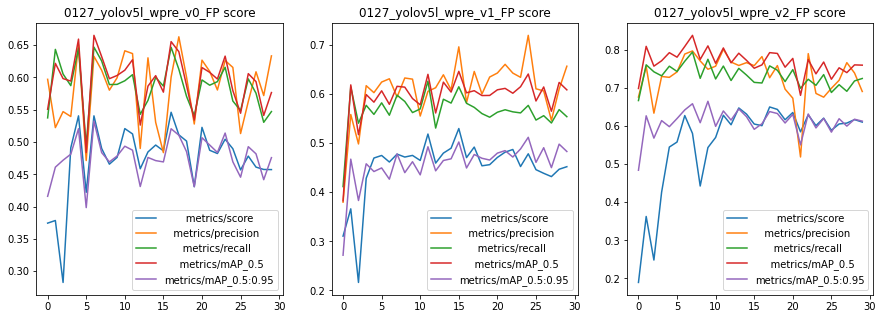

In [10]:
fig, axes = plt.subplots(1, len(meta_params),figsize=(5*len(meta_params), 5))
target_score = {}
for i,(model_version, params) in enumerate(meta_params.items()):
    if params["tools"] == "mmdetection":
        continue
    logging_dir = params["ckpt_path"].parent.parent
    res_df = pd.read_csv(logging_dir / "results.csv")    
    res_df[['       metrics/score','   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', ]].plot(ax=axes[i])
    axes[i].legend()
    axes[i].set_title(f"{model_version} score")    
    target_score[model_version] = res_df['       metrics/score'].max()
plt.show()    

In [11]:
target_score

{'0127_yolov5l_wpre_v0_FP': 0.54605,
 '0127_yolov5l_wpre_v1_FP': 0.5299,
 '0127_yolov5l_wpre_v2_FP': 0.65039}

In [12]:
models = {}
for model_version, params in meta_params.items():
    if params['tools'] == "yolov5":
        params["repo"] = Path("../yolov5/").resolve()
    else:
        ckp = glob(str(params['output_dir']) + "/" + "best*")[0]
        params['ckpt_path'] = ckp
    params["augment"]  = AUGMENT
    params["conf"] = CONF
    params["iou"] = IOU

    if USE_SAHI:
        model = Yolov5DetectionModel(
            model_path=str(params['ckpt_path']),
            confidence_threshold=CONF,
            image_size = params['img_size'],
            device="cuda:0", # or 'cuda:0'
        )    
    else:
        if params['tools']  == "yolov5":
            model = util.load_model(params)
            device = torch.device("cuda")
            model.to(device)
        elif params['tools'] == "mmdetection":
            model = init_detector(str(params['cfg_dir'] / "config.py"), ckp, device='cuda:0')
            
    models[model_version] = model    

YOLOv5 🚀 v6.0-186-g56783c1 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v6.0-186-g56783c1 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v6.0-186-g56783c1 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


# Prediction

In [13]:
meta_params[model_version]["fold"][0]

2

In [14]:
df["pred"] = None
for model_version in meta_params.keys():
    fold = meta_params[model_version]["fold"][0]
    df["pred_" + model_version + f"_fold{fold}"] = None
df.columns

Index(['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
       'annotations', 'fold', 'old_image_path', 'image_path', 'label_path',
       'real_bbox', 'num_bbox', 'pred', 'pred_0127_yolov5l_wpre_v0_FP_fold0',
       'pred_0127_yolov5l_wpre_v1_FP_fold1',
       'pred_0127_yolov5l_wpre_v2_FP_fold2'],
      dtype='object')

In [15]:
SH = 640
SW = 640
OHR = 0.2
OWR = 0.2
PMT = 0.2
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(14, 14))
for idx in tqdm(range(len(df))):
    row = df.loc[idx]
    target_fold = row['fold']
    img_path = row["image_path"]
    img = cv2.imread(str(img_path))
    for model_version, model in models.items():
        model_fold = meta_params[model_version]["fold"][0]
        if model_fold != target_fold:
            continue
            
        USE_CLACHE = meta_params[model_version].get("use_clahe", True)
        img2 = img.copy()
        if USE_CLACHE:
            for i in range(3):
                img2[:, :, i] = clahe.apply((img2[:, :, i]))     
                
        if meta_params[model_version]["tools"] == "yolov5":
            img2 = img2[...,::-1]
            if USE_SAHI:
                result_sliced = get_sliced_prediction(
                    img2,
                    model,
                    slice_height = SH,
                    slice_width = SW,
                    overlap_height_ratio = OHR,
                    overlap_width_ratio = OWR,
                    postprocess_match_threshold = PMT,
                    verbose = False)
                object_prediction_list = result_sliced.object_prediction_list
                confs = [obj_pred.score.value for obj_pred in object_prediction_list]
                pred_bbox = np.array([obj_pred.bbox.to_coco_bbox() for obj_pred in object_prediction_list])
            else:
                pred_bbox, confs = util.predict(model, img2, size=SIZE, augment=AUGMENT, use_sahi=USE_SAHI)

        elif meta_params[model_version]["tools"] == "mmdetection":
            result = inference_detector(model, img2)
            pred_bbox = result[0][:,:4]
            pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
            pred_confs = result[0][:,4]
            confs = pred_confs.tolist()
            
        df.at[idx, "pred_" + model_version + f"_fold{target_fold}"] = [ [conf] + pred_bbox[i].tolist() for i, conf in enumerate(confs)]
        df.at[idx, "pred"] = df.at[idx, "pred_" + model_version + f"_fold{target_fold}"]

  0%|          | 0/23501 [00:00<?, ?it/s]

In [16]:
#save it
util.save_pickle(df, "pred_all_large_wpre_video_FP.pkl")

# Pick Conf Thresh

In [44]:
def run_wbf(bboxes, confs, image_size=1280, iou_thr=0.4, skip_box_thr=0.7, weights=None, conf_type='avg'):
    if len(bboxes) == 1:
        return bboxes[0], confs[0], []    
    boxes =  [bbox / (image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(len(conf)) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type)
    boxes = boxes * (image_size-1)
    return boxes, scores, labels

In [45]:
pred_col = "pred"
gt_bboxs_list = []
for idx in range(len(df)):
    row = df.iloc[idx]
    if row[pred_col] is None:
        continue
    gt_bboxs = row["real_bbox"]
    gt_bboxs_list.append(np.array(gt_bboxs))

In [47]:
#conf_ths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
#conf_ths = [12, 16, 18, 20, 22, 24]
conf_ths = [6, 8, 10, 12, 14]
#conf_ths = [20, 24, 26, 28, 30]
#conf_ths = [30, 32, 35, 38, 45, 50, 55]
#conf_ths = [32, 34, 40, 45, 50]
iou_ths = np.arange(0.3, 0.85, 0.05)
for conf_th in conf_ths:
    conf_th /= 100
    prd_bboxs_list = []
    for index in df.index:
        if df.loc[index, "pred"] is None:
            continue
        prd_bboxs = df.loc[index, pred_col]
        prd_bboxs = [p for p in prd_bboxs if p[0] >= conf_th]
        #prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(prd_bboxs)) if prd_bboxs[i][0] >= conf_th]
        prd_bboxs_list.append(np.array(prd_bboxs))
    tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
    #df["tp"], df["fp"], df["fn"] = tps, fps, fns    
    precision = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=0)
    recall = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=100)    
    score = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=2) 
    #score_only_bbox =  util.f_beta(*df.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
    print(f"conf_th {conf_th:.2f}, pred: f2 {score:.4f}, precision {precision:.2f}, recall {recall:.2f} ")

conf_th 0.06, pred: f2 0.5946, precision 0.50, recall 0.62 
conf_th 0.08, pred: f2 0.6007, precision 0.55, recall 0.61 
conf_th 0.10, pred: f2 0.6030, precision 0.59, recall 0.61 
conf_th 0.12, pred: f2 0.6037, precision 0.62, recall 0.60 
conf_th 0.14, pred: f2 0.6034, precision 0.64, recall 0.59 


# Tracking

In [48]:
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

def tracking_function(tracker, frame_id, bboxes, scores, best_conf):
    
    detects = []
    predictions = []
    
    if len(scores)>0:
        for i in range(len(bboxes)):
            # remember to check
            if scores[i] <= best_conf:
                continue
            box = bboxes[i]
            score = scores[i]
            x_min = int(box[0])
            y_min = int(box[1])
            bbox_width = int(box[2])
            bbox_height = int(box[3])
            detects.append([x_min, y_min, x_min+bbox_width, y_min+bbox_height, score])
            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
#             print(predictions[:-1])
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        
    return predictions

In [49]:
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

In [50]:
BEST_CONF = 0.12
frame_id = 0
prd_bboxs_tracking_list = []
for idx in range(len(df)):
    row = df.iloc[idx]
    prd_bboxs = row["pred"]
    if prd_bboxs is None:
        continue
    bboxes, confis = [p[1:] for p in prd_bboxs], [p[0] for p in prd_bboxs]    
    predictions = tracking_function(tracker, frame_id, bboxes, confis, BEST_CONF)    
    prd_bboxs_tracking =   [[float(p) for p in pred.split(" ")] for pred in predictions]
    prd_bboxs_tracking_list.append(np.array(prd_bboxs_tracking))
    frame_id += 1
    
tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
#df["tp"], df["fp"], df["fn"] = tps, fps, fns    
precision = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=0)
recall = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=100)    
score = util.f_beta(np.sum(tps), np.sum(fps), np.sum(fns), beta=2) 
print(f"Adding tracking, pred: f2 {score:.4f}, precision {precision:.2f}, recall {recall:.2f}")

Adding tracking, pred: f2 0.6034, precision 0.64, recall 0.59


# check image